In [1]:
import numpy as np
import control as ct
import scipy.signal as sig
import control.matlab as ctm
import matplotlib.pyplot as plt

from numpy import linalg

R1 = 35.8e3         # Resistência de Entrada
R2 = 17.95e3        # Resistência do Circuito RC
C1 = 54e-9          # Capacitância do Circuito RC
C2 = 697.7e-9       # Capacitância do Ampop

A  = [[0            , 1/C1],
      [-1/(R1*R2*C2) , -((1/(R1*C2))+(1/(R2*C2)))]]
A = np.array(A)

B  = [[0],
      [1/(R1*R2*C2)]]
B = np.array(B)

C  = [[1, 0]]
C = np.array(C)

D  = 0

sys = ct.ss(A, B, C, D)

In [2]:
tf = 80e-3
t  = np.linspace(0, tf, 500)
u  = np.ones(len(t))

x0 = np.array([[0],
               [0]])

Y, t, X = ctm.lsim(sys, u, t, x0)

In [3]:
x1sim = X[:, 0]
x2sim = X[:, 1]

In [4]:
ζ  = (C1*R2+C1*R1)/(2*C1*C2*R1*np.sqrt(1/(C1*C2*R1*R2))*R2)
ω  = np.sqrt(1/(C1*C2*R1*R2))
ωd = ω*np.sqrt(1-ζ**2)

f  = 250*ωd/(2*np.pi)
T  = 1/f

print("f:", f)
print("T:", T)

Kmax = int(t[-1]/T+1)
k = np.linspace(0, Kmax, Kmax+1)
u = np.ones(len(k))

f: 7726.675615122535
T: 0.00012942176555759825


In [5]:
x1  = np.zeros(len(k))
x2  = np.zeros(len(k))
dx1 = np.zeros(len(k))
dx2 = np.zeros(len(k))
y   = np.zeros(len(k))

# condições iniciais (podem ser diferentes de zero)
x1[0]  = x0[0]  #  para k = 0
x2[0]  = x0[1]  #  para k = 0
dx1[0] = 0  #  para k = 0
dx2[0] = 0  #  para k = 0
y[0]   = C[0,0]*x1[0]+C[0,1]*x2[0] + D*u[0]  #  para k = 0

In [6]:
# Planta + Observador

Ke = [2.50486083e+02, 2.25925056e-03]

x1_obs  = x1.copy()
x2_obs  = x2.copy()
y_obs   = y.copy()

dx1_obs = dx1.copy()
dx2_obs = dx2.copy()

for n in range(1, Kmax+1):
    #- Planta -#
    # Equações dos integradores
    x1[n]=T*dx1[n-1]+x1[n-1]
    x2[n]=T*dx2[n-1]+x2[n-1]
    # Equação diferencial de estados:  Xponto=A*X+B*U
    dx1[n]=A[0,0]*x1[n]+A[0,1]*x2[n] + B[0]*u[n]
    dx2[n]=A[1,0]*x1[n]+A[1,1]*x2[n] + B[1]*u[n]
    # Equação de Saída: Y=C*X+D*U
    y[n] = C[0,0]*x1[n]+C[0,1]*x2[n] + D*u[n]

    #- Observador -#
    # Equações dos integradores
    x1_obs[n]=T*dx1_obs[n-1]+x1_obs[n-1]
    x2_obs[n]=T*dx2_obs[n-1]+x2_obs[n-1]
    # Equação de Saída: Y=C*X+D*U
    y_obs[n] = C[0,0]*x1_obs[n]+C[0,1]*x2_obs[n] + D*u[n]
    # Equação diferencial de estados:  Xponto=A*X+B*U
    dx1_obs[n]=A[0,0]*x1_obs[n]+A[0,1]*x2_obs[n] + B[0]*u[n] + Ke[0]*(y[n] - y_obs[n])
    dx2_obs[n]=A[1,0]*x1_obs[n]+A[1,1]*x2_obs[n] + B[1]*u[n] + Ke[1]*(y[n] - y_obs[n])

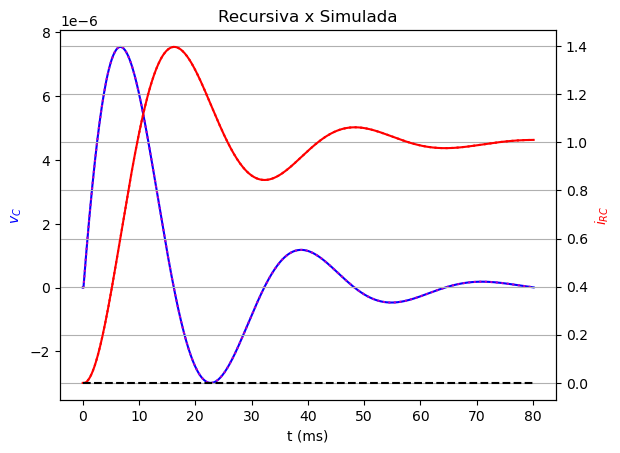

In [7]:
tsim = 1e3*T*k

fig, ax1 = plt.subplots()
ax1.set_xlabel("t (ms)")
ax1.set_ylabel("$v_{C}$", color='b')
ax1.plot(tsim, x2, 'b')
ax1.plot(tsim, x2_obs, 'm:')

ax2 = ax1.twinx()
ax2.set_ylabel("$i_{RC}$", color='r')
ax2.plot(tsim, x1, 'r')
ax2.plot(tsim, x1_obs, 'r:')
ax2.plot([0, t[-1]*1e3], [0, 0], 'k--')
plt.title("Recursiva x Simulada")
plt.grid(True)
plt.show()

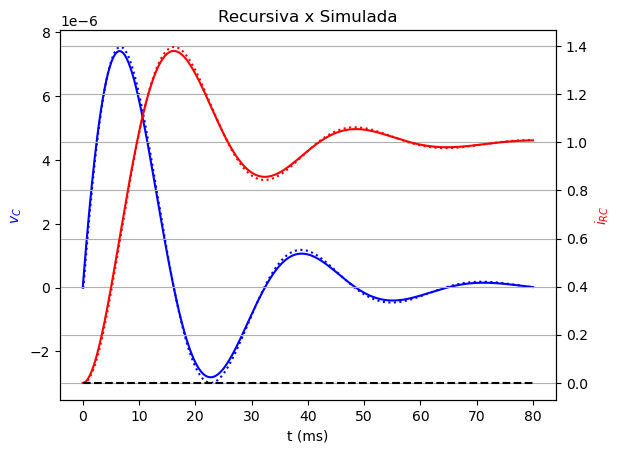

In [8]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("t (ms)")
ax1.set_ylabel("$v_{C}$", color='b')
ax1.plot(t*1e3, x2sim, 'b')
ax1.plot(k*T*1e3, x2, 'b:')

ax2 = ax1.twinx()
ax2.set_ylabel("$i_{RC}$", color='r')
ax2.plot(t*1e3, x1sim, 'r')
ax2.plot(k*T*1e3, x1, 'r:')
ax2.plot([0, t[-1]*1e3], [0, 0], 'k--')
plt.title("Recursiva x Simulada")
plt.grid(True)
plt.show()

In [9]:
print("Diff x1:", np.mean(abs(100*(x1_obs-x1))))
print("Diff x2:", np.mean(abs(100*(x2_obs-x2))))

Diff x1: 0.0
Diff x2: 0.0


In [20]:
# Planta + Observador Indireto

u   = np.ones(len(k))
x1  = np.zeros(len(k))
x2  = np.zeros(len(k))
dx1 = np.zeros(len(k))
dx2 = np.zeros(len(k))
y   = np.zeros(len(k))

x1_obs  = x1.copy()
x2_obs  = x2.copy()
dx1_obs  = dx1.copy()
dx2_obs  = dx2.copy()

for n in range(1, Kmax+1):
    #- Planta -#
    # Equações dos integradores
    x1[n]=T*dx1[n-1]+x1[n-1]
    x2[n]=T*dx2[n-1]+x2[n-1]
    # Equação diferencial de estados:  Xponto=A*X+B*U
    dx1[n]=A[0,0]*x1[n]+A[0,1]*x2[n] + B[0]*u[n]
    dx2[n]=A[1,0]*x1[n]+A[1,1]*x2[n] + B[1]*u[n]
    # Equação de Saída: Y=C*X+D*U
    y[n] = C[0,0]*x1[n]+C[0,1]*x2[n] + D*u[n]

    #- Observador -#
    # Estimando Valores
    x1_obs[n]  = y[n] # x2 igual a saída da planta
    dx1_obs[n] = (y[n]-y[n-1])/T

    x2_obs[n-1] = C1*dx1_obs[n]
    dx2_obs[n] = (x2_obs[n]-x2_obs[n-1])/T

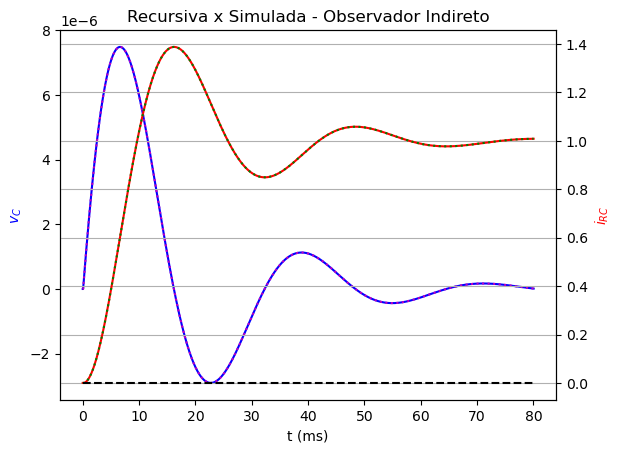

In [21]:
tsim = 1e3*T*k

fig, ax1 = plt.subplots()
ax1.set_xlabel("t (ms)")
ax1.set_ylabel("$v_{C}$", color='b')
ax1.plot(tsim, x2, 'b')
ax1.plot(tsim, x2_obs, 'm:')

ax2 = ax1.twinx()
ax2.set_ylabel("$i_{RC}$", color='r')
ax2.plot(tsim, x1, 'r')
ax2.plot(tsim, x1_obs, 'g:')
ax2.plot([0, t[-1]*1e3], [0, 0], 'k--')
plt.title("Recursiva x Simulada - Observador Indireto")
plt.grid(True)
plt.show()

In [22]:
print("Diff x1:", np.mean(abs(100*(x1_obs-x1))))
print("Diff x2:", np.mean(abs(100*(x2_obs-x2))))

Diff x1: 0.0
Diff x2: 1.033376094026539e-09


In [13]:
# Período de Amostragem Ajustado Para a Planta Controlada

Mpc = 7*2e-2 * (1 - 10e-2)
Tpc = 14*1e-3 * (1 - 10e-2)

ζ  = -np.log(Mpc)/np.sqrt(np.pi**2 + np.log(Mpc)**2)
ω  = 3/(ζ*Tpc)
ωd = ω*np.sqrt(1-ζ**2)

f  = 250*ωd/(2*np.pi)
T  = 1/f

Kmax = int(t[-1]/T+1)
k = np.linspace(0, Kmax, Kmax+1)

# Controlador com Planta
r  = np.ones(len(k))
u  = np.zeros(len(k))
ξ  = np.zeros(len(k))
dξ = np.zeros(len(k))

x1  = np.zeros(len(k))
x2  = np.zeros(len(k))
dx1 = np.zeros(len(k))
dx2 = np.zeros(len(k))
y   = np.zeros(len(k))

Ki = 2.73996858e+03
K  = [1.07069485e+01, 5.60654181e+05]

y_prev = 0
for n in range(1, Kmax+1):
    #- Controlador -#
    dξ[n] = r[n] - y[n-1]
    ξ[n]  = T*dξ[n-1] + ξ[n-1]
    u[n]  = Ki*ξ[n] - (K[0]*x1[n-1] + K[1]*x2[n-1])

    #- Planta -#
    # Equações dos integradores
    x1[n]=T*dx1[n-1]+x1[n-1]
    x2[n]=T*dx2[n-1]+x2[n-1]
    # Equação diferencial de estados:  Xponto=A*X+B*U
    dx1[n]=A[0,0]*x1[n]+A[0,1]*x2[n] + B[0]*u[n]
    dx2[n]=A[1,0]*x1[n]+A[1,1]*x2[n] + B[1]*u[n]
    # Equação de Saída: Y=C*X+D*U
    y[n]   = C[0,0]*x1[n]+C[0,1]*x2[n] + D*u[n]
    y_prev = y[n]

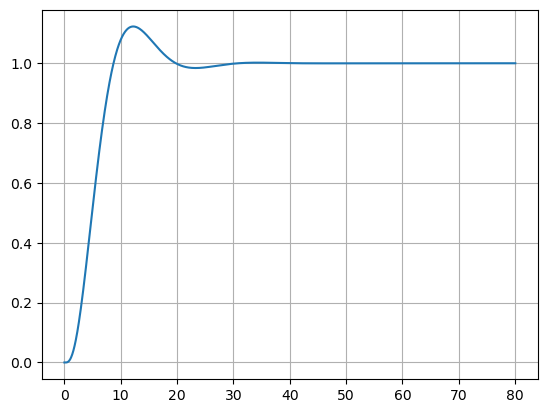

In [14]:
tsim = 1e3*T*k

plt.plot(tsim, y)
plt.grid()
plt.show()

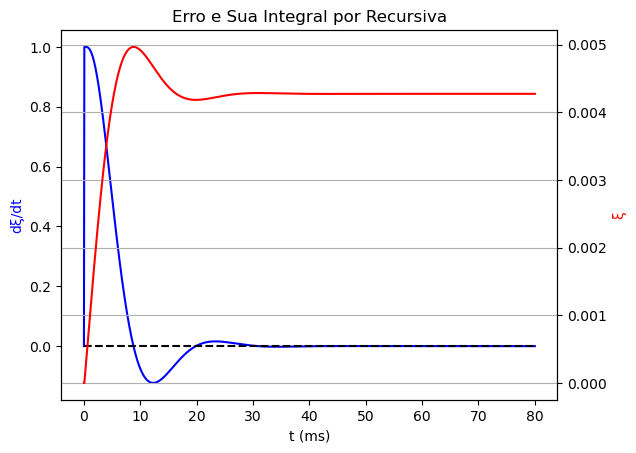

In [15]:
tsim = 1e3*T*k

fig, ax1 = plt.subplots()
ax1.set_xlabel("t (ms)")
ax1.set_ylabel("dξ/dt", color='b')
ax1.plot(tsim, dξ, 'b')
ax1.plot([0, t[-1]*1e3], [0, 0], 'k--')

ax2 = ax1.twinx()
ax2.set_ylabel("ξ", color='r')
ax2.plot(tsim, ξ, 'r')
plt.title("Erro e Sua Integral por Recursiva")
plt.grid(True)
plt.show()

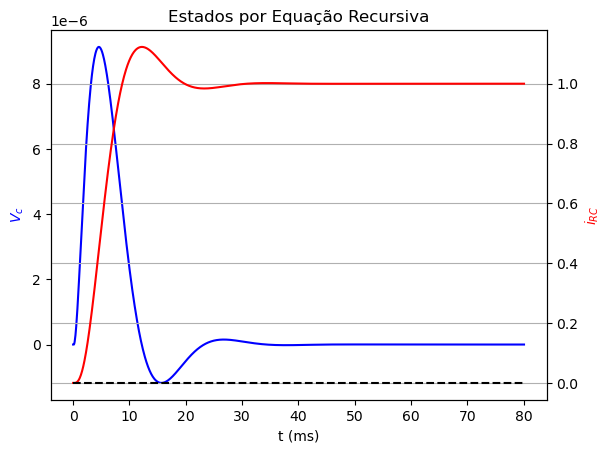

In [16]:
tsim = 1e3*T*k

fig, ax1 = plt.subplots()
ax1.set_xlabel("t (ms)")
ax1.set_ylabel("$V_c$", color='b')
ax1.plot(tsim, x2, 'b')

ax2 = ax1.twinx()
ax2.set_ylabel("$i_{RC}$", color='r')
ax2.plot(tsim, x1, 'r')
ax2.plot([0, t[-1]*1e3], [0, 0], 'k--')
plt.title("Estados por Equação Recursiva")
plt.grid(True)
plt.show()

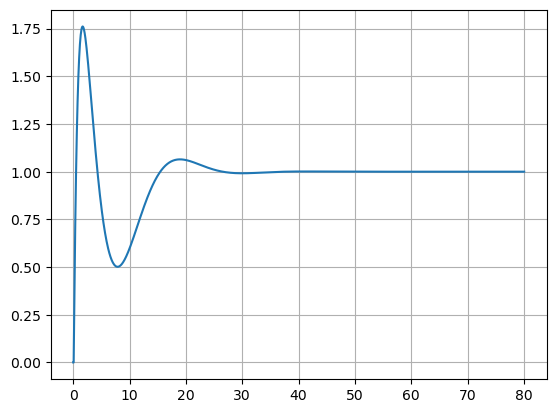

In [17]:
plt.plot(tsim, u)
plt.grid()
plt.show()

In [18]:
Kmax = int(t[-1]/T+1)
k = np.linspace(0, Kmax, Kmax+1)

# Controlador com Planta e Observador
r  = np.ones(len(k))
u  = np.zeros(len(k))
ξ  = np.zeros(len(k))
dξ = np.zeros(len(k))

x1  = np.zeros(len(k))
x2  = np.zeros(len(k))
dx1 = np.zeros(len(k))
dx2 = np.zeros(len(k))
y   = np.zeros(len(k))

Ki = 2.73996858e+03
K  = [1.07069485e+01, 5.60654181e+05]

x1_obs  = x1.copy()
x2_obs  = x2.copy()
dx1_obs = dx1.copy()
dx2_obs = dx2.copy()
y_obs   = y.copy()

Ke = [2.25925056e-03, 2.50486083e+02]

y_prev = 0
for n in range(1, Kmax+1):
    #- Controlador -#
    dξ[n] = r[n] - y[n-1]
    ξ[n]  = T*dξ[n-1] + ξ[n-1]
    u[n]  = Ki*ξ[n] - (K[0]*x1_obs[n-1] + K[1]*x2_obs[n-1])

    #- Planta -#
    # Equações dos integradores
    x1[n]=T*dx1[n-1]+x1[n-1]
    x2[n]=T*dx2[n-1]+x2[n-1]
    # Equação diferencial de estados:  Xponto=A*X+B*U
    dx1[n]=A[0,0]*x1[n]+A[0,1]*x2[n] + B[0]*u[n]
    dx2[n]=A[1,0]*x1[n]+A[1,1]*x2[n] + B[1]*u[n]
    # Equação de Saída: Y=C*X+D*U
    y[n]   = C[0,0]*x1[n]+C[0,1]*x2[n] + D*u[n]
    y_prev = y[n]

    #- Observador -#
    # Equações dos integradores
    x1_obs[n]=T*dx1_obs[n-1]+x1_obs[n-1]
    x2_obs[n]=T*dx2_obs[n-1]+x2_obs[n-1]
    # Equação de Saída: Y=C*X+D*U
    y_obs[n] = C[0,0]*x1_obs[n]+C[0,1]*x2_obs[n] + D*u[n]
    # Equação diferencial de estados:  Xponto=A*X+B*U
    dx1_obs[n]=A[0,0]*x1_obs[n]+A[0,1]*x2_obs[n] + B[0]*u[n] + Ke[0]*(y[n] - y_obs[n])
    dx2_obs[n]=A[1,0]*x1_obs[n]+A[1,1]*x2_obs[n] + B[1]*u[n] + Ke[1]*(y[n] - y_obs[n])

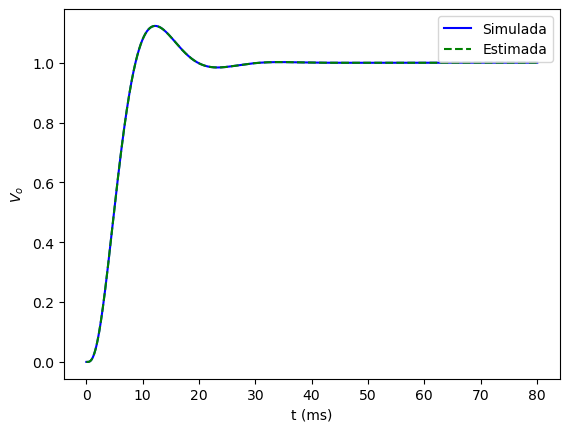

In [19]:
tsim = 1e3*k*T

plt.plot(tsim, y, 'b')
plt.plot(tsim, y_obs, 'g--')
plt.legend(["Simulada", "Estimada"])
plt.xlabel("t (ms)")
plt.ylabel("$V_o$")
plt.show()